In [2]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:35: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps,
/home/daniel/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:597: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  eps=np.finfo(np.float).eps, copy_X=Tr

In [4]:
df = pd.read_csv('data/data_rho.csv')

Xs    = df.Xs
Ys    = df.Ys

prop_final = df.rho_resta_final_exp
samplig_freq = 1

In [5]:
#klicker used
df_arm1 = pd.read_csv('data/arm_tracing_arm1_rho.csv')
df_arm1['arm'] = [1]*len(df_arm1)
df_arm1['id'] = np.arange(0,len(df_arm1),1)
df_arm1 = df_arm1[::samplig_freq].reset_index(drop=True)

#klicker used
df_arm2 = pd.read_csv('data/arm_tracing_arm2_rho.csv')
df_arm2['arm'] = [2]*len(df_arm2)
df_arm2['id'] = np.arange(0,len(df_arm2),1)
df_arm2 = df_arm2[::samplig_freq].reset_index(drop=True)

df_arms = pd.concat([df_arm1,df_arm2], axis = 0).reset_index(drop=True)

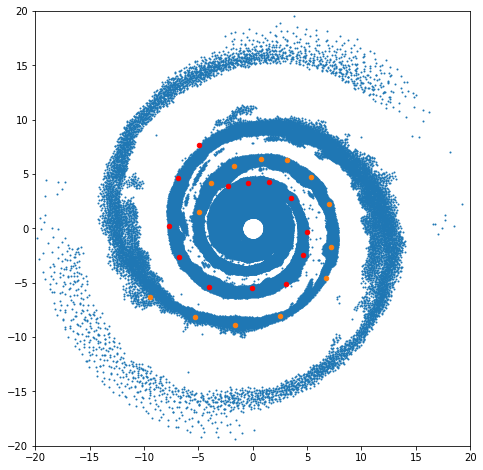

In [6]:
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(df.Xs, df.Ys, s = 1)
ax.scatter(df_arm1.x, df_arm1.y, s = 20, color = 'red')
ax.scatter(df_arm2.x, df_arm2.y, s = 20, color = 'C1')
R = 20
ax.set_xlim(-R,R)
ax.set_ylim(-R,R)
ax.set_aspect('equal')


## Polar Space (r,theta)

/home/daniel/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


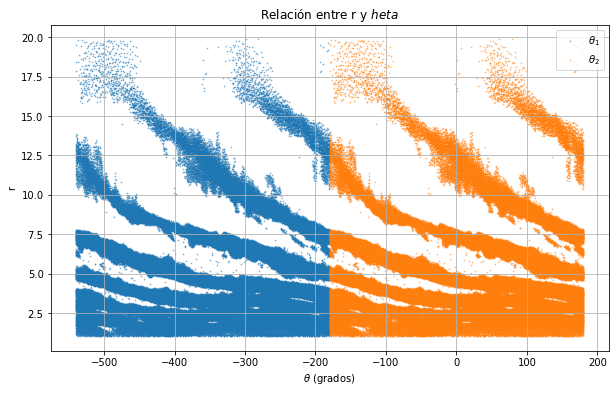

In [7]:
df['r'] = np.sqrt(df['Xs']**2 + df['Ys']**2)

# Calcular theta
df['theta1'] = (180 * np.arctan2(df['Ys'], df['Xs']) / np.pi) - 360
df['theta2'] = (180 * np.arctan2(df['Ys'], df['Xs']) / np.pi)


# Calcular las coordenadas polares r y theta
df['r'] = np.sqrt(df['Xs']**2 + df['Ys']**2)

# Calcular las variaciones de theta
df['theta1'] = (180 * np.arctan2(df['Ys'], df['Xs']) / np.pi) - 360
df['theta2'] = (180 * np.arctan2(df['Ys'], df['Xs']) / np.pi)

# Graficar theta1 y theta2 en la misma gráfica
plt.figure(figsize=(10, 6))

# Graficar theta1
plt.scatter(df['theta1'], df['r'], alpha=0.5, s=0.50, label=r'$\theta_1$')
# Graficar theta2
plt.scatter(df['theta2'], df['r'], alpha=0.5, s=0.50, label=r'$\theta_2$')

# Configurar la gráfica
plt.title('Relación entre r y $\theta$')
plt.xlabel(r'$\theta$ (grados)')
plt.ylabel('r')
plt.legend()
plt.grid(True)

# Mostrar la gráfica
plt.show();

## Código Iterativo 

In [10]:
# Coordenadas polares
df['r'] = np.sqrt(df['Xs']**2 + df['Ys']**2)
df['theta'] = np.degrees(np.arctan2(df['Ys'], df['Xs']))
df['theta'] = np.where(df['theta'] < 0, df['theta'] + 360, df['theta'])

# Filtrar puntos por el cuartil 75%
threshold = df['rho_resta_final_exp'].quantile(0.85)
df_filtered = df[df['rho_resta_final_exp'] > threshold].sort_values(by='rho_resta_final_exp', ascending=False).reset_index(drop=True)

# Inicializar variables
groups = []  # Lista para almacenar los grupos
discarded_points = []  # Lista para puntos descartados
radius_tolerance = 1.15  # Radio de tolerancia alrededor del ajuste
flexible_pa_range = (4.0, 30.0)  # Rango más flexible para PA

# Funciones auxiliares
def calculate_distance(slope, intercept, theta, r):
    predicted_r = slope * theta + intercept
    return abs(predicted_r - r)

def calculate_pa(slope, intercept):
    """Calcula el Position Angle (PA) en grados."""
    if intercept != 0:
        return np.degrees(np.arctan((slope * (180 / np.pi)) / intercept))
    return np.nan  # Evitar divisiones por cero

def is_valid_pa(pa, valid_range):
    return valid_range[0] <= abs(pa) <= valid_range[1]

# Crear grupos de tres puntos y evaluar
while len(df_filtered) >= 3:
    # Seleccionar los primeros tres puntos
    initial_points = df_filtered.iloc[:3]
    df_filtered = df_filtered.iloc[3:]

    X = initial_points[['theta']].values
    y = initial_points['r'].values

    # Ajustar modelo lineal
    model = LinearRegression()
    model.fit(X, y)
    slope = model.coef_[0]
    intercept = model.intercept_
    pa = calculate_pa(slope, intercept)

    # Crear el grupo inicial
    group = {'points': initial_points, 'slope': slope, 'intercept': intercept, 'pa': pa}

    if is_valid_pa(pa, flexible_pa_range) and intercept > 0:
        groups.append(group)
    else:
        discarded_points.extend(initial_points.to_dict('records'))

    # Evaluar los puntos restantes
    to_remove = []
    for i, row in df_filtered.iterrows():
        theta_next = row['theta']
        r_next = row['r']
        distance = calculate_distance(slope, intercept, theta_next, r_next)

        if distance <= radius_tolerance:
            # Agregar punto al grupo existente
            X_new = np.vstack([group['points'][['theta']].values, [[theta_next]]])
            y_new = np.hstack([group['points']['r'].values, r_next])
            model.fit(X_new, y_new)

            group['points'] = pd.concat([group['points'], row.to_frame().T], ignore_index=True)
            group['slope'] = model.coef_[0]
            group['intercept'] = model.intercept_
            group['pa'] = calculate_pa(group['slope'], group['intercept'])

            to_remove.append(i)

    # Eliminar los puntos ya asignados al grupo
    df_filtered = df_filtered.drop(to_remove).reset_index(drop=True)

# Extrapolar ajustes para grupos grandes
for group in groups:
    if len(group['points']) > 3000:
        theta_line = np.linspace(df['theta'].min(), df['theta'].max(), 1000)
        slope = group['slope']
        intercept = group['intercept']
        r_line = slope * theta_line + intercept

        for i, row in df_filtered.iterrows():
            theta_next = row['theta']
            r_next = row['r']
            distance = calculate_distance(slope, intercept, theta_next, r_next)

            if distance <= radius_tolerance:
                X_new = np.vstack([group['points'][['theta']].values, [[theta_next]]])
                y_new = np.hstack([group['points']['r'].values, r_next])
                model.fit(X_new, y_new)

                group['points'] = pd.concat([group['points'], row.to_frame().T], ignore_index=True)
                group['slope'] = model.coef_[0]
                group['intercept'] = model.intercept_
                group['pa'] = calculate_pa(group['slope'], group['intercept'])
                df_filtered = df_filtered.drop(i).reset_index(drop=True)

# Reprocesar puntos descartados
discarded_points_df = pd.DataFrame(discarded_points)
if not discarded_points_df.empty:
    for _, point in discarded_points_df.iterrows():
        theta_next = point['theta']
        r_next = point['r']
        assigned_to_group = False

        for group in groups:
            slope = group['slope']
            intercept = group['intercept']
            pa = group['pa']

            distance = calculate_distance(slope, intercept, theta_next, r_next)

            if distance <= radius_tolerance:
                X_new = np.vstack([group['points'][['theta']].values, [[theta_next]]])
                y_new = np.hstack([group['points']['r'].values, r_next])
                model.fit(X_new, y_new)

                group['points'] = pd.concat([group['points'], point.to_frame().T], ignore_index=True)
                group['slope'] = model.coef_[0]
                group['intercept'] = model.intercept_
                group['pa'] = calculate_pa(group['slope'], group['intercept'])

                assigned_to_group = True
                break

        if not assigned_to_group:
            discarded_points_df = discarded_points_df.append(point);

/home/daniel/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:121: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



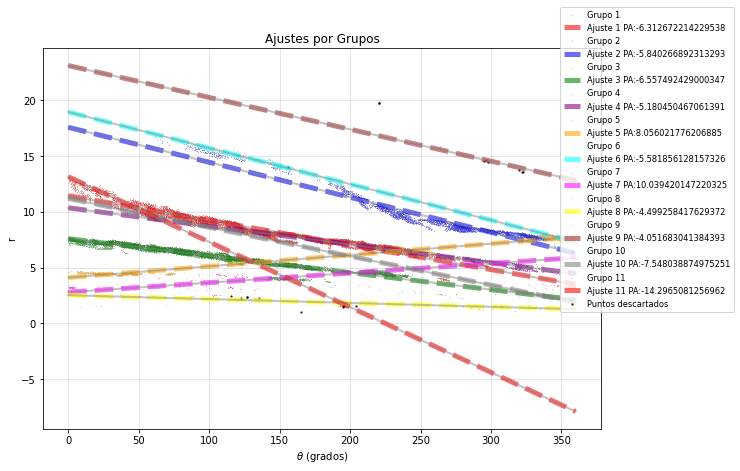

In [11]:
# Graficar ajustes
plt.figure(figsize=(10, 7))

colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'gray']

for idx, group in enumerate(groups):
    points = group['points']
    slope = group['slope']
    intercept = group['intercept']
    pa = group['pa'] 

    plt.scatter(points['theta'], points['r'], s=0.80, alpha=0.46, edgecolor='gray', linewidths=0.12,
                label=f'Grupo {idx+1}', color=colors[idx % len(colors)])

    theta_line = np.linspace(df['theta'].min(), df['theta'].max(), 1000)
    r_line = slope * theta_line + intercept
    plt.plot(theta_line, r_line, linestyle='--', linewidth=5, alpha=0.58, label=f'Ajuste {idx+1} PA:{pa}', color=colors[idx % len(colors)])
    plt.plot(theta_line, r_line, linestyle='-', linewidth=2.03, alpha=0.48, color='gray')

# Graficar puntos descartados
if not discarded_points_df.empty:
    plt.scatter(discarded_points_df['theta'], discarded_points_df['r'], s=2, alpha=0.65, color='black', label='Puntos descartados')

plt.title("Ajustes por Grupos")
plt.xlabel(r'$\theta$ (grados)')
plt.ylabel('r')
plt.legend(loc='upper left', bbox_to_anchor=(0.92, 1.12), fontsize=8.3)
plt.grid(True, alpha=0.4)
plt.show()

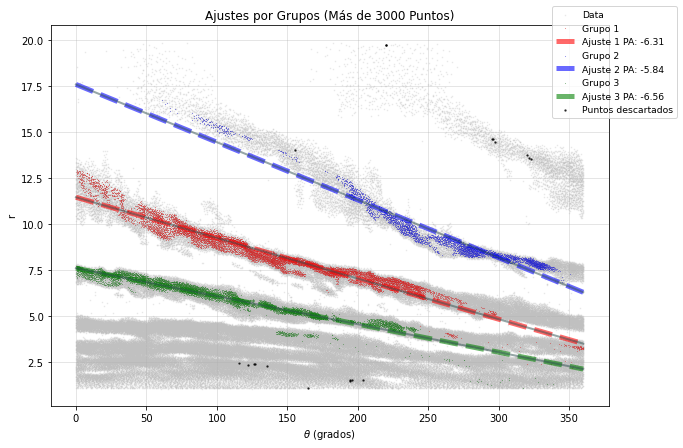

In [12]:
# Graficar ajustes (grupos con más de 3000 puntos)
plt.figure(figsize=(10, 7))

colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan', 'magenta', 'yellow', 'brown', 'gray']
plt.scatter(df['theta'],df['r'], s=0.36, alpha=0.314, color='silver', label='Data')

for idx, group in enumerate(groups):
    if len(group['points']) > 3000:  # Filtrar grupos con más de 3000 puntos
        points = group['points']
        slope = group['slope']
        intercept = group['intercept']
        pa = group['pa'] 

        plt.scatter(points['theta'], points['r'], s=0.980, alpha=0.49, edgecolor='gray', linewidths=0.12,
                    label=f'Grupo {idx+1}', color=colors[idx % len(colors)])

        theta_line = np.linspace(df['theta'].min(), df['theta'].max(), 1000)
        r_line = slope * theta_line + intercept
        plt.plot(theta_line, r_line, linestyle='--', linewidth=5, alpha=0.59, label=f'Ajuste {idx+1} PA: { pa:.2f}', color=colors[idx % len(colors)])
        plt.plot(theta_line, r_line, linestyle='-', linewidth=2.03, alpha=0.50, color='darkslategray')

# Graficar puntos descartados (opcional, mantener por claridad)
if not discarded_points_df.empty:
    plt.scatter(discarded_points_df['theta'], discarded_points_df['r'], s=2, alpha=0.65, color='black', label='Puntos descartados')
plt.title("Ajustes por Grupos (Más de 3000 Puntos)")
plt.xlabel(r'$\theta$ (grados)')
plt.ylabel('r')
plt.legend(loc='upper left', bbox_to_anchor=(0.8902, 1.062), fontsize=9.3)
plt.grid(True, alpha=0.4)
plt.show()


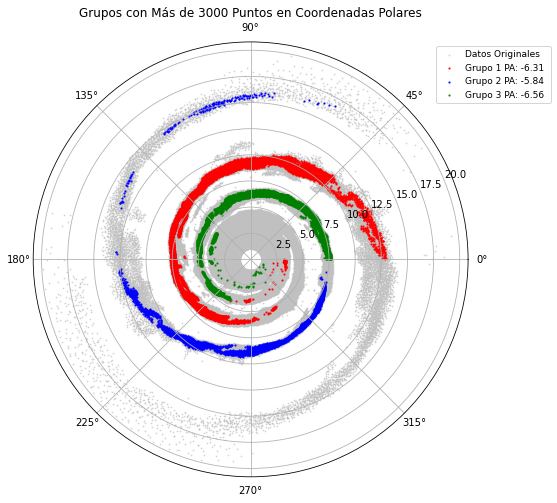

In [13]:
# Graficar en coordenadas polares los grupos con más de 3000 puntos
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(9, 8))

# Graficar todos los puntos en coordenadas polares
theta_all = np.radians(df['theta'])
ax.scatter(theta_all, df['r'], s=0.6, alpha=0.6, color='silver', label='Datos Originales')

for idx, group in enumerate(groups):
    if len(group['points']) > 3000:
        points = group['points']
        theta_group = np.radians(points['theta'])
        r_group = points['r']
        pa = group['pa'] 


        
        ax.scatter(theta_group, r_group, s=1.5, alpha=0.8, label=f'Grupo {idx+1} PA: {pa:.2f} ', color=colors[idx % len(colors)])

# Configuración de la gráfica en coordenadas polares
ax.set_title("Grupos con Más de 3000 Puntos en Coordenadas Polares")
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0), fontsize=9)
plt.show()


In [14]:

# Mostrar información de los grupos
for idx, group in enumerate(groups):
    print(f"Grupo {idx+1}:")
    print(f" Pendiente: {group['slope']:.4f}, Intercepto: {group['intercept']:.4f}")
    print(f" PA (grados): {group['pa']:.4f}")
    print(f" Puntos en el grupo: {len(group['points'])}")
    print()

# Mostrar puntos descartados
print("Puntos descartados:")
if discarded_points_df.empty:
    print(" No se descartaron puntos.")
else:
    print(discarded_points_df)


Grupo 1:
 Pendiente: -0.0221, Intercepto: 11.4493
 PA (grados): -6.3127
 Puntos en el grupo: 8102

Grupo 2:
 Pendiente: -0.0314, Intercepto: 17.5840
 PA (grados): -5.8403
 Puntos en el grupo: 3065

Grupo 3:
 Pendiente: -0.0152, Intercepto: 7.5920
 PA (grados): -6.5575
 Puntos en el grupo: 5824

Grupo 4:
 Pendiente: -0.0164, Intercepto: 10.3585
 PA (grados): -5.1805
 Puntos en el grupo: 545

Grupo 5:
 Pendiente: 0.0101, Intercepto: 4.1036
 PA (grados): 8.0560
 Puntos en el grupo: 1017

Grupo 6:
 Pendiente: -0.0323, Intercepto: 18.9544
 PA (grados): -5.5819
 Puntos en el grupo: 305

Grupo 7:
 Pendiente: 0.0086, Intercepto: 2.7878
 PA (grados): 10.0394
 Puntos en el grupo: 180

Grupo 8:
 Pendiente: -0.0035, Intercepto: 2.5214
 PA (grados): -4.4993
 Puntos en el grupo: 51

Grupo 9:
 Pendiente: -0.0286, Intercepto: 23.1194
 PA (grados): -4.0517
 Puntos en el grupo: 27

Grupo 10:
 Pendiente: -0.0259, Intercepto: 11.2025
 PA (grados): -7.5480
 Puntos en el grupo: 3

Grupo 11:
 Pendiente: -0.0